In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
)
from torch.utils.data import DataLoader, TensorDataset

from src.model.mlp_samadhi import MlpSamadhiModel
from src.train.anomaly_trainer import AnomalySamadhiTrainer


warnings.filterwarnings("ignore")

In [2]:
# --- Configuration ---
DATA_PATH = "../data/creditcard.csv"
BATCH_SIZE = 256
EPOCHS_PRETRAIN = 10
EPOCHS_MAIN = 10
LATENT_DIM = 32
N_PROBES = 5

CONFIG = {
    "dim": LATENT_DIM,
    "input_dim": 29,
    "n_probes": N_PROBES,
    "refine_steps": 5,
    "softmax_temp": 0.5,
    "gate_threshold": 0.5,
    "stability_coeff": 0.1,
    "entropy_coeff": 0.05,
    "balance_coeff": 1.0,
    "mix_alpha": 0.5,
    "probe_trainable": True,
    "vicara_type": "standard",
    "adapter_hidden_dim": 64,
    "training_attention_mode": "soft",
    "prediction_attention_mode": "hard",
    "anomaly_margin": 10.0,
    "anomaly_weight": 1.0,
}

In [3]:
def load_data_semi_supervised(path):
    print(f"Loading data from {path}...")
    try:
        df = pd.read_csv(path)
    except FileNotFoundError:
        # Fallback for different execution contexts
        df = pd.read_csv("../" + path)

    df = df.drop(columns=["Time"])

    scaler = StandardScaler()
    df["Amount"] = scaler.fit_transform(df["Amount"].values.reshape(-1, 1))

    normal_df = df[df["Class"] == 0]
    fraud_df = df[df["Class"] == 1]

    # Split Normal (80/20)
    train_normal, test_normal = train_test_split(normal_df, test_size=0.2, random_state=42)

    # Split Fraud (50/50) - Use half for training (to teach "Bad")
    train_fraud, test_fraud = train_test_split(fraud_df, test_size=0.5, random_state=42)

    # Train Set (Normal + Fraud)
    train_df = pd.concat([train_normal, train_fraud])

    # Test Set (Normal + Fraud)
    test_df = pd.concat([test_normal, test_fraud])

    print(f"Train: Normal={len(train_normal)}, Fraud={len(train_fraud)}")
    print(f"Test : Normal={len(test_normal)}, Fraud={len(test_fraud)}")

    X_train = torch.tensor(train_df.drop(columns=["Class"]).values, dtype=torch.float32)
    y_train = torch.tensor(train_df["Class"].values, dtype=torch.long)  # Need labels for training now

    X_test = torch.tensor(test_df.drop(columns=["Class"]).values, dtype=torch.float32)
    y_test = torch.tensor(test_df["Class"].values, dtype=torch.long)

    return X_train, y_train, X_test, y_test

In [4]:
def create_dataloader(X, y, batch_size=BATCH_SIZE, shuffle=True):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [5]:
# --- 1. 評価実行関数 (計算のみ) ---
def evaluate_anomaly_detection_with_gate(model, dataloader):
    """モデルを実行し、必要な全結果（再構築誤差、Confidence、Winner ID、Gate Openフラグ）を返す。"""
    model.eval()
    device = next(model.parameters()).device

    reconstruction_errors = []
    confidences = []
    winner_probes = []
    gate_opens = []

    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)

            # A. Search (Vitakka)
            s0, meta = model.vitakka(x)
            conf = meta["confidence"]
            winner = meta["winner_id"]
            is_open = meta["gate_open"]  # Tensor of bools

            # B. Refine (Vicara)
            s_final, _, _ = model.vicara(s0, context=meta)

            # C. Reconstruct (Decoder)
            x_recon = model.decoder(s_final)

            # Metrics
            mse = torch.mean((x - x_recon) ** 2, dim=1)

            reconstruction_errors.append(mse.cpu())
            confidences.append(conf.cpu())
            winner_probes.append(winner.cpu())
            gate_opens.append(is_open.cpu())

    recon_errs = torch.cat(reconstruction_errors).numpy()
    confs = torch.cat(confidences).numpy()
    winners = torch.cat(winner_probes).numpy()
    gates = torch.cat(gate_opens).numpy()  # True/Falseの配列

    # ゲート通過フラグも一緒に返却する
    return recon_errs, confs, winners, gates


# --- 2. 分析・プロット関数 (表示ロジックを統合) ---
def analyze_and_plot_results(y_true, recon_errs, confs, winners, gates):
    """
    評価結果の配列と真値を受け取り、全ての統計分析、ゲート分析、分類レポート、可視化を実行する。
    """

    # --- 1. Gating Analysis (門前払い数) ---
    print("\n--- Gating Analysis (門前払い数) ---")

    normal_total = np.sum(y_true == 0)
    fraud_total = np.sum(y_true == 1)

    # 正常データ(y=0)でのゲート通過率
    normal_passed = np.sum(gates[y_true == 0])
    print(f"Normal: {normal_passed}/{normal_total} passed ({normal_passed/normal_total:.2%})")

    # 不正データ(y=1)でのゲート通過率
    fraud_passed = np.sum(gates[y_true == 1])
    print(f"Fraud : {fraud_passed}/{fraud_total} passed ({fraud_passed/fraud_total:.2%})")

    # --- 2. Detailed Metrics ---
    print("\n--- Detailed Analysis ---")

    # Mean Stats
    print(f"{'Class':<10} | {'Mean Recon Err':<15} | {'Mean Conf':<10}")
    print("-" * 45)
    print(f"{'Normal':<10} | {np.mean(recon_errs[y_true==0]):<15.4f} | {np.mean(confs[y_true==0]):<10.4f}")
    print(f"{'Fraud':<10} | {np.mean(recon_errs[y_true==1]):<15.4f} | {np.mean(confs[y_true==1]):<10.4f}")

    # Probe Usage
    print("\n--- Probe Usage Distribution ---")
    n_probes = CONFIG["n_probes"]
    normal_winners = winners[y_true == 0]
    fraud_winners = winners[y_true == 1]

    # 省略: Probe Usageの表示ロジックは元のコードからそのまま使用

    # ROC-AUC
    roc_recon = roc_auc_score(y_true, recon_errs)
    print("\n--- ROC-AUC Scores ---")
    print(f"Reconstruction Error (Higher is Anomaly): {roc_recon:.4f}")

    # Classification Report (Optimizing Threshold by F1)
    print("\n--- Classification Performance (Reconstruction Error) ---")
    precision, recall, thresholds = precision_recall_curve(y_true, recon_errs)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    print(f"Best Threshold (F1-Max): {best_threshold:.4f}")

    y_pred = (recon_errs > best_threshold).astype(int)
    print(classification_report(y_true, y_pred, target_names=["Normal", "Fraud"]))
    print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")

    # --- 3. Visualization ---
    # プロットロジックは元のコードからそのまま使用 (plt.figure, sns.kdeplot, plt.scatterなど)
    # ...

    plt.figure(figsize=(18, 5))

    # Plot 1: Reconstruction Error
    plt.subplot(1, 3, 1)
    sns.kdeplot(recon_errs[y_true == 0], fill=True, label="Normal", clip=(0, 5))
    sns.kdeplot(recon_errs[y_true == 1], fill=True, label="Fraud", clip=(0, 5))
    plt.title("Reconstruction Error Density")
    plt.xlabel("MSE Loss")
    plt.legend()

    # Plot 2: Confidence
    plt.subplot(1, 3, 2)
    sns.kdeplot(confs[y_true == 0], fill=True, label="Normal", clip=(0, 1))
    sns.kdeplot(confs[y_true == 1], fill=True, label="Fraud", clip=(0, 1))
    plt.title("Confidence Density")
    plt.xlabel("Confidence Score")
    plt.legend()

    # Plot 3: Scatter (Recon vs Conf)
    plt.subplot(1, 3, 3)
    idx_normal = np.where(y_true == 0)[0]
    if len(idx_normal) > 2000:
        idx_normal = np.random.choice(idx_normal, 2000, replace=False)
    idx_fraud = np.where(y_true == 1)[0]

    plt.scatter(confs[idx_normal], recon_errs[idx_normal], alpha=0.3, label="Normal", s=10)
    plt.scatter(confs[idx_fraud], recon_errs[idx_fraud], alpha=0.6, label="Fraud", s=20, color="red")
    plt.title("Confidence vs Reconstruction Error")
    plt.xlabel("Confidence")
    plt.ylabel("Reconstruction Error")
    plt.ylim(0, 5)
    plt.legend()

    plt.show()

    # best_thresholdを返却することで、テストデータでの評価に利用可能にする
    return best_threshold

In [6]:
# New function to evaluate on train data for threshold determination
def evaluate_train_data(model, dataloader, y_true_tensor):
    model.eval()
    device = next(model.parameters()).device
    recon_errs = []
    y_true_list = []

    with torch.no_grad():
        for batch in dataloader:
            x_batch, y_batch = batch
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)  # Ensure y_batch is also on device for filtering

            # Filter out only the Normal and Fraud data that were part of the training set
            # This is important if you mixed normal and fraud in training
            # For thresholding, we need to consider both classes present in the training for PR curve.
            # We use all data in the train_loader to calculate errors for thresholding.

            s0, meta = model.vitakka(x_batch)
            s_final, _, _ = model.vicara(s0, context=meta)
            x_recon = model.decoder(s_final)

            mse = torch.mean((x_batch - x_recon) ** 2, dim=1)
            recon_errs.append(mse.cpu())
            y_true_list.append(y_batch.cpu())

    return torch.cat(recon_errs).numpy(), torch.cat(y_true_list).numpy()

In [7]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")


X_train, y_train, X_test, y_test = load_data_semi_supervised(DATA_PATH)
train_loader = create_dataloader(X_train, y_train, shuffle=True)
test_loader = create_dataloader(X_test, y_test, shuffle=False)

model = MlpSamadhiModel(CONFIG).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Use Anomaly Trainer
trainer = AnomalySamadhiTrainer(model, optimizer)

# 1. Pretrain (Normal Only inside)
print("Creating Autoencoder DataLoader (Normal Only)...")
X_train_normal = X_train[y_train == 0]
y_train_normal = y_train[y_train == 0] # 実質全て0だが、形式を合わせるために作成
train_autoencoder_loader = create_dataloader(X_train_normal, y_train_normal, batch_size=BATCH_SIZE, shuffle=True)
trainer.pretrain_autoencoder(train_autoencoder_loader, epochs=EPOCHS_PRETRAIN)

Using device: mps
Loading data from ../data/creditcard.csv...
Train: Normal=227452, Fraud=246
Test : Normal=56863, Fraud=246
Trainer initialized on device: mps
Creating Autoencoder DataLoader (Normal Only)...

==================== Starting Autoencoder Pre-training (Normal Only) ====================
Pre-train Epoch 1/10, Avg Recon Loss (Normal): 0.2175
Pre-train Epoch 2/10, Avg Recon Loss (Normal): 0.0593
Pre-train Epoch 3/10, Avg Recon Loss (Normal): 0.0339
Pre-train Epoch 4/10, Avg Recon Loss (Normal): 0.0285
Pre-train Epoch 5/10, Avg Recon Loss (Normal): 0.0203
Pre-train Epoch 6/10, Avg Recon Loss (Normal): 0.0180
Pre-train Epoch 7/10, Avg Recon Loss (Normal): 0.0160
Pre-train Epoch 8/10, Avg Recon Loss (Normal): 0.0153
Pre-train Epoch 9/10, Avg Recon Loss (Normal): 0.0117
Pre-train Epoch 10/10, Avg Recon Loss (Normal): 0.0176
==================== Autoencoder Pre-training Complete ====================



In [8]:
# 2. Init Probes (Normal Only for centroids)
print("--- Initializing Probes with Normal Data ---")
model.eval()
latents = []
with torch.no_grad():
    for batch in train_loader:
        x, y = batch
        x = x.to(device)
        # Filter Normal
        x_normal = x[y == 0]
        if len(x_normal) > 0:
            z = model.vitakka.adapter(x_normal)
            latents.append(z.cpu().numpy())

latents = np.concatenate(latents, axis=0)
# Subsample for KMeans if too large
if len(latents) > 10000:
    indices = np.random.choice(len(latents), 10000, replace=False)
    latents_sub = latents[indices]
else:
    latents_sub = latents

kmeans = KMeans(n_clusters=CONFIG["n_probes"], random_state=42)
kmeans.fit(latents_sub)
centroids = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)
model.load_probes(centroids)
print("Probes initialized.")

--- Initializing Probes with Normal Data ---
Probes initialized.


In [9]:
# 3. Main Training (With Margin Loss)
trainer.fit(train_loader, epochs=EPOCHS_MAIN)


--- Start Anomaly Training (Margin Loss) ---
Device: mps
Params: Margin=10.0, Anomaly Weight=1.0
Epoch 1/10 | Batch 850 | Loss: 0.5109
Epoch 1 Finished. Avg Loss: 1.2030
Epoch 2/10 | Batch 850 | Loss: 0.3334
Epoch 2 Finished. Avg Loss: 0.7750
Epoch 3/10 | Batch 850 | Loss: 0.2357
Epoch 3 Finished. Avg Loss: 0.6687
Epoch 4/10 | Batch 850 | Loss: 0.3639
Epoch 4 Finished. Avg Loss: 0.6431
Epoch 5/10 | Batch 850 | Loss: 0.2243
Epoch 5 Finished. Avg Loss: 0.7025
Epoch 6/10 | Batch 850 | Loss: 0.1885
Epoch 6 Finished. Avg Loss: 0.5679
Epoch 7/10 | Batch 850 | Loss: 0.2230
Epoch 7 Finished. Avg Loss: 0.5666
Epoch 8/10 | Batch 850 | Loss: 0.2907
Epoch 8 Finished. Avg Loss: 0.6358
Epoch 9/10 | Batch 850 | Loss: 0.2004
Epoch 9 Finished. Avg Loss: 0.5648
Epoch 10/10 | Batch 850 | Loss: 0.1689
Epoch 10 Finished. Avg Loss: 0.5472


[1.2030162925465724,
 0.7749823219153319,
 0.6686666063378366,
 0.6431363380357121,
 0.7024970619196302,
 0.5678537874576751,
 0.5666343535181512,
 0.6358369720283519,
 0.5648314088750421,
 0.5471644026928404]

In [10]:
# 4. Determine Threshold using Training Data
print("\n--- Determining Threshold using Training Data ---")
recon_errs_train, y_true_train = evaluate_train_data(model, train_loader, y_train)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_true_train, recon_errs_train)
f1_scores_train = 2 * recall_train * precision_train / (recall_train + precision_train + 1e-10)
best_idx_train = np.argmax(f1_scores_train)
best_threshold = thresholds_train[best_idx_train]
print(f"Best Threshold (F1-Max on Training Data): {best_threshold:.4f}")


--- Determining Threshold using Training Data ---
Best Threshold (F1-Max on Training Data): 11.9171



--- Gating Analysis (門前払い数) ---
Normal: 56817/56863 passed (99.92%)
Fraud : 52/246 passed (21.14%)

--- Detailed Analysis ---
Class      | Mean Recon Err  | Mean Conf 
---------------------------------------------
Normal     | 0.2145          | 0.2437    
Fraud      | 33.0524         | 0.3181    

--- Probe Usage Distribution ---

--- ROC-AUC Scores ---
Reconstruction Error (Higher is Anomaly): 0.9594

--- Classification Performance (Reconstruction Error) ---
Best Threshold (F1-Max): 12.2527
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56863
       Fraud       0.78      0.81      0.80       246

    accuracy                           1.00     57109
   macro avg       0.89      0.91      0.90     57109
weighted avg       1.00      1.00      1.00     57109

Confusion Matrix:
[[56806    57]
 [   46   200]]


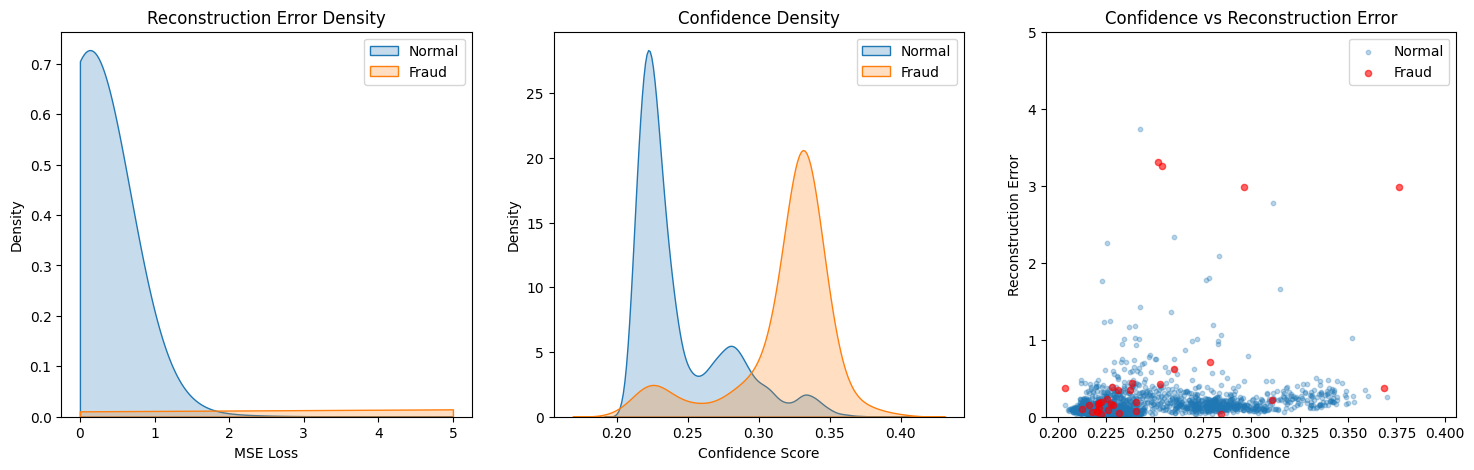


--- Evaluation on Test Data (using F1-optimized threshold) ---
Mean Recon Error (Normal): 0.2145
Mean Recon Error (Fraud) : 33.0524
Ratio (Fraud/Normal)     : 154.07x
ROC-AUC: 0.9594

--- Classification Performance (Reconstruction Error) on Test Data ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56863
       Fraud       0.78      0.81      0.80       246

    accuracy                           1.00     57109
   macro avg       0.89      0.91      0.90     57109
weighted avg       1.00      1.00      1.00     57109



In [11]:
# 1. モデルの評価実行
# y_test.numpy()は analyze_and_plot_results に渡すため、ここでは不要
recon_errs, confs, winners, gates = evaluate_anomaly_detection_with_gate(model, test_loader)
y_true_test = y_test.numpy()

# 2. 結果の分析とプロット、F1に基づく最適な閾値を決定
best_threshold = analyze_and_plot_results(y_true_test, recon_errs, confs, winners, gates)

# 3. テストデータでの最終的な分類性能評価 (analyze_and_plot_results内で既に実行されているが、
# 別のブロックとして切り出す場合は以下を使用)

print("\n--- Evaluation on Test Data (using F1-optimized threshold) ---")

# (analyze_and_plot_resultsで計算された) best_threshold を使用して予測
y_pred_test = (recon_errs > best_threshold).astype(int)

# 分析に必要な統計を表示
normal_err_test = np.mean(recon_errs[y_true_test == 0])
fraud_err_test = np.mean(recon_errs[y_true_test == 1])
roc_test = roc_auc_score(y_true_test, recon_errs)

print(f"Mean Recon Error (Normal): {normal_err_test:.4f}")
print(f"Mean Recon Error (Fraud) : {fraud_err_test:.4f}")
print(f"Ratio (Fraud/Normal)     : {fraud_err_test/normal_err_test:.2f}x")
print(f"ROC-AUC: {roc_test:.4f}")

# 分類レポートと混同行列を表示
print("\n--- Classification Performance (Reconstruction Error) on Test Data ---")
print(classification_report(y_true_test, y_pred_test, target_names=["Normal", "Fraud"]))